<a href="https://colab.research.google.com/github/nadundesilva/colab-notebooks/blob/main/notebooks/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import os
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
from getpass import getpass
from io import StringIO
from ipywidgets import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score

In [66]:
SEED = 17

## Load Data

In [67]:
if not os.path.exists("colab-notebooks"):
  ! git clone https://github.com/nadundesilva/colab-notebooks.git
else:
  print("Not cloning nadundesilva/colab-notebooks repository as it already exists")

Not cloning nadundesilva/colab-notebooks repository as it already exists


In [68]:
KAGGLE_DATA_DIR = "colab-notebooks/datasets/kaggle/kashnitsky/mlcourse"

try:
  %mkdir -p "$KAGGLE_DATA_DIR"
  %pushd "$KAGGLE_DATA_DIR"
  if len([x for x in os.listdir() if not x.startswith(".")]) == 0:
    os.environ['KAGGLE_USERNAME'] = input("Kaggle Username: ")
    os.environ['KAGGLE_KEY'] = getpass(prompt="Kaggle Key: ")

    !kaggle datasets download -d kashnitsky/mlcourse
    !unzip *.zip
    !rm *.zip
  else:
    print("Not downloading data set as it is already present in directory")
finally:
  %popd

def load_df(name: str):
  return pd.read_csv((os.path.join(KAGGLE_DATA_DIR, name)))

/content/colab-notebooks/datasets/kaggle/kashnitsky/mlcourse
Not downloading data set as it is already present in directory
/content
popd -> /content


## Decision Trees

### Load Data Frame

In [69]:
df = load_df("telecom_churn.csv")

In [70]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      3333 non-null   

### Preprocessing

In [72]:
df["International plan"] = df["International plan"].map({"Yes": 1, "No": 1})
df["Voice mail plan"] = df["Voice mail plan"].map({"Yes": 1, "No": 1})
df["Churn"] = df["Churn"].astype("int")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,1,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,1,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,1,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [73]:
states = df.pop("State")
states.head()

0    KS
1    OH
2    NJ
3    OH
4    OK
Name: State, dtype: object

In [74]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,1,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,1,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,1,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [75]:
X, y = df.drop("Churn", axis=1), df["Churn"]
X.shape, y.shape

((3333, 18), (3333,))

In [76]:
X.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,1,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,1,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,1,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [77]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

In [78]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=.3, random_state=SEED)
X_train.shape, X_holdout.shape, y_train.shape, y_holdout.shape

((2333, 18), (1000, 18), (2333,), (1000,))

### Simple Fit Predict

#### Train Model

In [79]:
tree = DecisionTreeClassifier(random_state=SEED)

In [80]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

#### Evaluate Model

In [81]:
pred_holdout = tree.predict(X=X_holdout)
pred_holdout.shape, y_holdout.shape

((1000,), (1000,))

In [82]:
accuracy_score(y_true=y_holdout, y_pred=pred_holdout)

0.864

In [83]:
y.value_counts(normalize=True)

0    0.855086
1    0.144914
Name: Churn, dtype: float64

#### Cross Validation

In [84]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [85]:
cv_accuracies_by_depth = []
holdout_accuracies_by_depth = []
max_depth_values = np.arange(2, 11)

for max_depth in tqdm(max_depth_values):
  tree = DecisionTreeClassifier(random_state=SEED, max_depth=max_depth)

  # Cross Validation Assessment
  val_scores = cross_val_score(estimator=tree, X=X_train, y=y_train, cv=skf)
  cv_accuracies_by_depth.append(val_scores.mean())

  # Holdout Assessment
  tree.fit(X_train, y_train)
  pred_holdout = tree.predict(X_holdout)
  holdout_accuracies_by_depth.append(accuracy_score(y_holdout, pred_holdout))

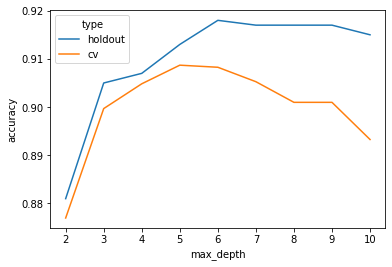

In [86]:
accuracies = pd.DataFrame({
    "max_depth": [x for x in max_depth_values] + [x for x in max_depth_values],
    "type": ["holdout" for x in holdout_accuracies_by_depth] + ["cv" for x in cv_accuracies_by_depth],
    "accuracy": holdout_accuracies_by_depth + cv_accuracies_by_depth
})
sns.lineplot(data=accuracies, x="max_depth", y="accuracy", hue="type")

### Hyperparameter Tuning

#### Grid Search

In [87]:
param_grid = {
    "max_depth": np.arange(2, 11),
    "min_samples_leaf": np.arange(2, 11)
}
param_grid

{'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [88]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [89]:
best_tree = GridSearchCV(estimator=tree, param_grid=param_grid, cv=skf, n_jobs=-1, verbose=1)

In [90]:
best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:    4.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=10,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             p

In [91]:
best_tree.best_params_

{'max_depth': 6, 'min_samples_leaf': 3}

In [92]:
best_tree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

#### Evaluate Model

##### Cross Validation Assessment

In [93]:
best_tree.best_score_

0.9138368363492662

##### Holdout Assessment

In [94]:
pred_holdout = best_tree.predict(X_holdout)

In [95]:
accuracy_score(y_true=y_holdout, y_pred=pred_holdout)

0.916

### Visualizations

In [96]:
dot_data = StringIO()
export_graphviz(decision_tree=best_tree.best_estimator_, out_file=dot_data, filled=True,
                feature_names=df.drop("Churn", axis=1).columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x11a\x00\x00\x03\x91\x08\x06\x00\x00\x00\x8d\x04\xd7…

## Linear Regression